In [1]:
from CNN import CNN
from trainTest import trainTest
from SingleCellDataset import SingleCellDataset

import os
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from tifffile import imread
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from skimage.measure import regionprops_table
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

In [ ]:
dataPath = '/project/zunderlab/heussner/Projects/morph/data/CODEX_LN/'
savePath = '/project/zunderlab/heussner/Projects/morph/results/'

markers = ['DAPI','CD8','CD3','CD20','Ki67','CD68','PanCK','CD21','CD4','CD31','CD45RO','CD11c','HLA-DR']

results_dict = {}

before_pearson = []
after_pearson = []
before_spearman = []
after_spearman = []

table = pd.read_csv(os.path.join(dataPath,'CODEX_LN_table.csv'))

for marker in markers:
    print(marker)
    tilePath = os.path.join(dataPath,f'CODEX_LN_tiles/{marker}.pkl')
    with open(tilePath,'rb') as handle:
        tiles = pickle.load(handle)
        
    labelOrder = [] # need order of cells to match X's and Y's
    X = []
    meanIntensities = []
    for label, tile in tiles.items():
        labelOrder.append(label)#.  .append(int(p.split('_')[1].split('.')[0])) # file name corresponds to cell ID
        meanIntensities.append(np.mean(tile[tile>0]))
        X.append(tile)
    
    X = np.array(X)
    meanIntensities = np.array(meanIntensities)
    labelOrder = np.array(labelOrder)
    
    sample_indices = random.sample([i for i in range(len(labelOrder))],5000)
    X = X[sample_indices]
    meanIntensities = meanIntensities[sample_indices]
    labelOrder = labelOrder[sample_indices]
    print('Loaded tiles')   
    table_ = table[table['label'].isin(list(labelOrder))].copy() # filter out unsampled cells
    table_ = table_.sort_values(by="label", key=lambda column: column.map(lambda e: list(labelOrder).index(e))) # sort table rows to be in same order as cell tiles
    
    Y = table_[marker].to_numpy() # select marker mean intensity
    Y = (Y - min(Y))/(max(Y) - min(Y)) # min-max norm
    
    xy = np.vstack([Y,np.array(meanIntensities)])
    z = gaussian_kde(xy)(xy) # density color

    plt.figure(figsize=(6,6))
    plt.scatter(Y, meanIntensities, s=15, c=z, cmap='magma', marker = '+')
    plt.xlabel(f'{marker} mean intensity')
    plt.ylabel(f'{marker} transformed mean intensity')
    plt.tight_layout()
    plt.savefig(os.path.join(savePath,f'{marker}_before.png'),dpi=500)
    #plt.show()

    before_pearson.append(pearsonr(Y, meanIntensities)[0])
    before_spearman.append(spearmanr(Y, meanIntensities)[0])
    print('Running model')
    # build model
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    epochs = 45
    batchSize = 16
    trainLoader = SingleCellDataset(X_train, Y_train)
    testLoader = SingleCellDataset(X_test, Y_test)

    model = CNN()

    result = trainTest(model, trainLoader, testLoader, batchSize, epochs)
    result.train()
    epoch_x = [i for i in range(epochs)]
    plt.figure(figsize=(6,6))
    plt.plot(epoch_x, result.trainLoss, label='train_loss')
    plt.plot(epoch_x, result.testLoss,, label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(savePath,f'{marker}_training_curve.png'),dpi=500)
    #plt.show()
    result.test()
    
    xy = np.vstack([Y_test,result.predictions])
    z = gaussian_kde(xy)(xy) # density color

    plt.figure(figsize=(6,6))
    plt.scatter(Y_test, result.predictions, s=15, c=z, cmap='magma', marker = '+')
    plt.xlabel(f'{marker} true mean intensity')
    plt.ylabel(f'{marker} predicted mean intensity')
    plt.tight_layout()
    plt.savefig(os.path.join(savePath,f'{marker}_after.png'),dpi=500)
    #plt.show()

    after_pearson.append(pearsonr(Y_test, Y_pred)[0])
    after_spearman.append(spearmanr(Y_test, Y_pred)[0])
    
    del X
    del Y
    del model
    del X_train
    del Y_train
    del X_test
    del Y_test

results_dict = {'before_pearson':before_pearson, 'after_pearson':after_pearson, 'before_spearman':before_spearman, 'after_spearman':after_spearman} 
    
with open(os.path.join(savePath,'CNNresults.pkl'),'wb') as handle:
    pickle.dump(results_dict, handle)

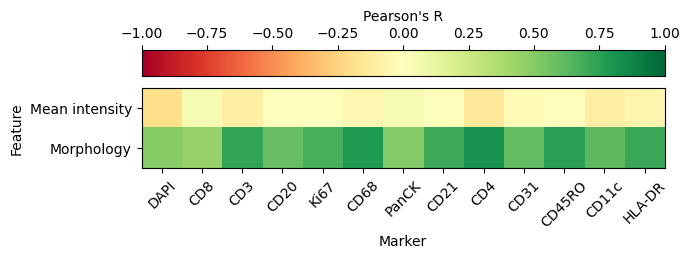

In [45]:
fig, ax = plt.subplots(figsize=(7,3))
im = ax.imshow(np.vstack([before_pearson, after_pearson]),vmin=-1,vmax=1,cmap='RdYlGn')
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label("Pearson's R")
ax.set_xticks([i for i in range(len(markers))],markers,rotation=45)
ax.set_yticks([0,1],['Mean intensity','Morphology'])
ax.set_xlabel('Marker')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(savePath,'PearsonCorrelation.png'),dpi=500, bbox_inches='tight')
plt.show()

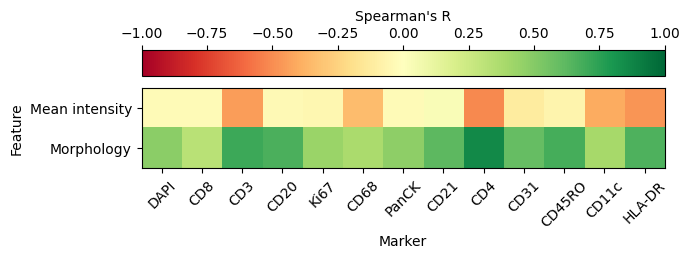

In [46]:
fig, ax = plt.subplots(figsize=(7,3))
im = ax.imshow(np.vstack([before_spearman, after_spearman]),vmin=-1,vmax=1,cmap='RdYlGn')
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label("Spearman's R")
ax.set_xticks([i for i in range(len(markers))],markers,rotation=45)
ax.set_yticks([0,1],['Mean intensity','Morphology'])
ax.set_xlabel('Marker')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(savePath,'SpearmanCorrelation.png'),dpi=500, bbox_inches='tight')
plt.show()